          Gene_set                      Term Overlap       P-value  \
0  KEGG_2021_Human             Breast cancer  14/147  4.743424e-28   
1  KEGG_2021_Human         Pancreatic cancer   12/76  2.215549e-26   
2  KEGG_2021_Human            Gastric cancer  13/149  2.955586e-25   
3  KEGG_2021_Human  Hepatocellular carcinoma  13/168  1.492420e-24   
4  KEGG_2021_Human         Colorectal cancer   11/86  5.789127e-23   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0      6.972834e-26            0                     0  696.491228   
1      1.628429e-24            0                     0  746.962500   
2      1.448237e-23            0                     0  474.284926   
3      5.484643e-23            0                     0  415.748387   
4      1.702003e-21            0                     0  486.640000   

   Combined Score                                              Genes  
0    43820.179710  BRAF;BRCA1;BRCA2;EGFR;MTOR;CDK6;PIK3CA;MYC;ERB...  
1    44124.35366

C:\Users\Imran Zafar\AppData\Local\Temp\ipykernel_23320\3769511294.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=enrichment_results['Term'].head(10), x=-np.log10(enrichment_results['P-value'].head(10)), palette="mako")


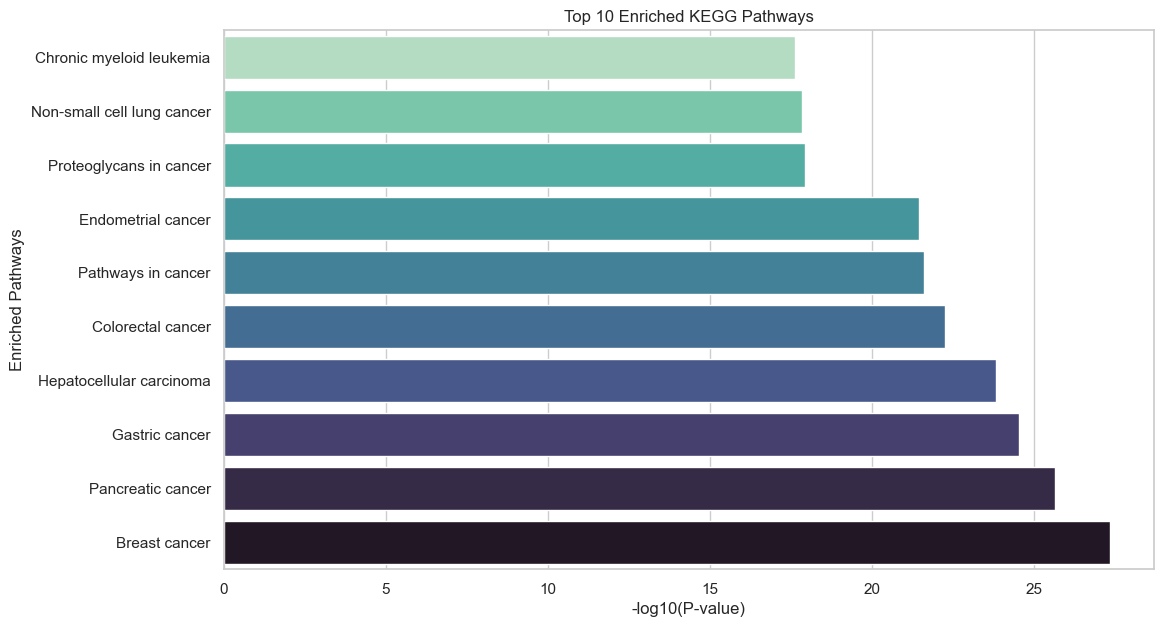

Error retrieving network data: Status Code 400
No network data available for visualization.


In [38]:
import pandas as pd
import requests
import gseapy as gp
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np

# Expanded list of top-ranked ncRNAs predicted by DRL model
top_ncRNAs = ['MALAT1', 'SNHG15', 'HOTAIR', 'NEAT1', 'TUG1', 'XIST', 'MEG3', 'UCA1', 'GAS5', 'LINC00152', 'LINC00473', 'PVT1']

# Function to retrieve target genes for ncRNAs (example using miRDB API or local dataset)
def get_target_genes(ncrna_list):
    target_genes = {}
    for ncRNA in ncrna_list:
        # Expanded gene list with oncogenes and tumor suppressors
        target_genes[ncRNA] = ['WNT1', 'CTNNB1', 'TGFBR1', 'TP53', 'KRAS', 'BRAF', 'SMAD4', 'MYC', 'EGFR', 'PIK3CA', 'AKT1', 'MTOR', 'CDK6', 'BRCA1', 'BRCA2', 'ERBB2', 'FOXO3']
    return target_genes

target_genes = get_target_genes(top_ncRNAs)

# Perform enrichment analysis using gseapy
def perform_enrichment(genes):
    try:
        enr = gp.enrichr(gene_list=genes, gene_sets='KEGG_2021_Human', organism='human')
        return enr.results
    except Exception as e:
        print("Error in enrichment analysis:", str(e))
        return pd.DataFrame()

# Validate biological pathways
enrichment_results = perform_enrichment([gene for genes in target_genes.values() for gene in genes])
if not enrichment_results.empty:
    print(enrichment_results.head())
    
    # Plot enrichment results
    plt.figure(figsize=(12, 7))
    sns.barplot(y=enrichment_results['Term'].head(10), x=-np.log10(enrichment_results['P-value'].head(10)), palette="mako")
    plt.xlabel("-log10(P-value)")
    plt.ylabel("Enriched Pathways")
    plt.title("Top 10 Enriched KEGG Pathways")
    plt.gca().invert_yaxis()
    plt.show()
else:
    print("No enrichment results available.")

# Validate network interactions using STRING API
STRING_API_URL = "https://string-db.org/api/json/network?identifiers="

def validate_network(genes):
    try:
        query = "%0d".join(genes)
        response = requests.get(STRING_API_URL + query)
        if response.status_code == 200:
            interactions = response.json()
            print("Protein-Protein Interactions Retrieved Successfully")
            return interactions
        else:
            print("Error retrieving network data: Status Code", response.status_code)
            return []
    except Exception as e:
        print("Exception occurred while fetching network data:", str(e))
        return []

network_data = validate_network([gene for genes in target_genes.values() for gene in genes])

# Visualize interaction network if data is available
if network_data:
    G = nx.Graph()
    for interaction in network_data:
        G.add_edge(interaction['preferredName_A'], interaction['preferredName_B'], weight=interaction['score'])
    
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    node_degree = dict(G.degree())
    nx.draw(G, pos, with_labels=True, node_color=list(node_degree.values()), cmap=plt.cm.viridis, edge_color='gray', node_size=3000, font_size=10)
    plt.title("Expanded Protein-Protein Interaction Network")
    plt.show()
else:
    print("No network data available for visualization.")
